In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
IMAGES_PATH = "./data/train2017/train2017"  # Directory with training images
VAL_IMAGES_PATH = "./data/val2017/val2017"  # Directory with validation images
CAPTIONS_PATH = "./data/annotations_trainval2017/annotations/captions_train2017.json"  # Caption file
VAL_CAPTIONS_PATH = "./data/annotations_trainval2017/annotations/captions_val2017.json"  # Validation caption file

In [6]:
from pycocotools.coco import COCO
coco = COCO(CAPTIONS_PATH)

print(len(list(coco.anns.keys())))  # Total number of annotations

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
591753


In [7]:
# import os
# from PIL import Image

# TRAIN_IMAGES_PATH = "./data/train2017/train2017"   # change if needed

# image_sizes = []
# count = 0

# for filename in os.listdir(TRAIN_IMAGES_PATH):
#     if filename.lower().endswith((".jpg", ".jpeg", ".png")):
#         img_path = os.path.join(TRAIN_IMAGES_PATH, filename)
#         try:
#             with Image.open(img_path) as img:
#                 width, height = img.size
#                 image_sizes.append((filename, width, height))
#         except:
#             print("Could not open:", filename)
#         count += 1
#         if count % 5000 == 0:
#             print(f"Processed {count} images...")

# print("Total images:", len(image_sizes))

In [8]:
import tqdm
import nltk 
from collections import Counter
nltk.download('punkt_tab')
import json

tokens = []
counter = Counter()

class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        self.add_word("<pad>")
        self.add_word("<start>")
        self.add_word("<end>")
        self.add_word("<unk>")

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json_path, threshold=5, limit =5000):
    with open(json_path, 'r') as f:
        data = json.load(f) 

    counter = Counter()
    count =0

    for ann in tqdm.tqdm(data['annotations']):
        caption = ann['caption'].lower()
        tokens = nltk.tokenize.word_tokenize(caption)
        counter.update(tokens)
        count +=1
        if count >= limit:
            break
    
    vocab = Vocabulary()
    for word, cnt in counter.items():
        if cnt >= threshold:
            vocab.add_word(word)
    
    return vocab

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [9]:
vocab = build_vocab(CAPTIONS_PATH, threshold=5, limit=5000)
print("Total vocabulary size:", len(vocab))

  1%|          | 4999/591753 [00:00<00:25, 23056.85it/s]

Total vocabulary size: 927


In [10]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [11]:

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    max_length = max(lengths)
    padded_captions = torch.zeros(len(captions), max_length).long()

    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]

    return images, padded_captions, lengths

In [12]:
from torch.utils.data import DataLoader
from dataset import CocoDataset

train_dataset = CocoDataset(
    root=IMAGES_PATH,
    json_path=CAPTIONS_PATH,
    vocab=vocab,
    transform=transform,
    max_samples=5000
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    collate_fn= collate_fn
)



loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [ ]:
from model import EncoderCNN, DecoderRNN
import torch.nn as nn

encoder = EncoderCNN(embed_size=256).to(device)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<pad>"])
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

for epoch in range(3):
    for images, captions, lengths in tqdm.tqdm(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        features = encoder(images)
        outputs = decoder(features, captions)

        loss = criterion(outputs.reshape(-1, len(vocab)), captions.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch:", epoch, "Loss:", loss.item())

d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 157/157 [00:22<00:00,  6.91it/s]


Epoch: 0 Loss: 2.9970314502716064


100%|██████████| 157/157 [00:18<00:00,  8.68it/s]


Epoch: 1 Loss: 2.6152219772338867


100%|██████████| 157/157 [00:18<00:00,  8.66it/s]

Epoch: 2 Loss: 2.4479634761810303


In [24]:
def generate_caption(image, encoder, decoder, vocab):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():    
        feature = encoder(image.unsqueeze(0))
        caption_ids = [vocab.word2idx["<start>"]]
        
        for _ in range(20):
            cap_tensor = torch.Tensor(caption_ids).long().unsqueeze(0).to(device)
            outputs = decoder(feature, cap_tensor)
            predicted = outputs.argmax(2)[:, -1].item()
            
            caption_ids.append(predicted)
            if vocab.idx2word[predicted] == "<end>":
                break

    return " ".join([vocab.idx2word[idx] for idx in caption_ids])

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Running Evaluation on 200 validation images...


  0%|          | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877128].


torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a woman woman in in a a kitchen kitchen with with a <unk> <unk> <unk> <unk> . . for Image ID: 000000397133.jpg


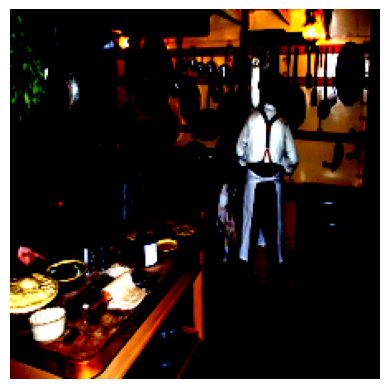

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].


BLEU-4 Score: 0.009591256528892601
torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a kitchen kitchen with with a <unk> stove <unk> and and a <unk> <unk> <unk> . . <end> for Image ID: 000000037777.jpg


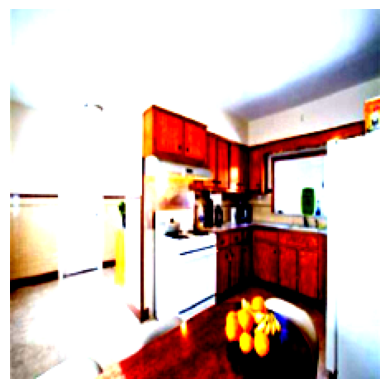

 20%|██        | 2/10 [00:00<00:00, 14.84it/s]

BLEU-4 Score: 0.007780488450465537
torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a man man in in a a <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> . . for Image ID: 000000252219.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


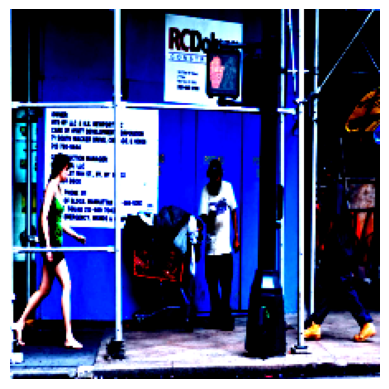

BLEU-4 Score: 0.0069961288797807395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a man man riding on a a motorcycle motorcycle with in a the <unk> background . . <end> for Image ID: 000000087038.jpg


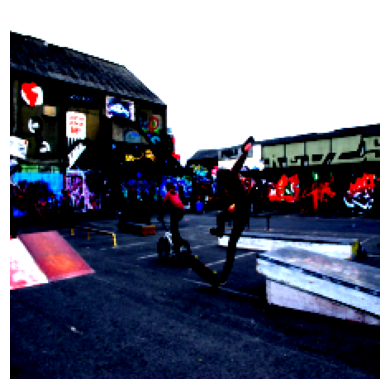

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


BLEU-4 Score: 0.0066672260968605596
torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a man man riding on a a motorcycle motorcycle with in a the <unk> background . . <end> for Image ID: 000000174482.jpg


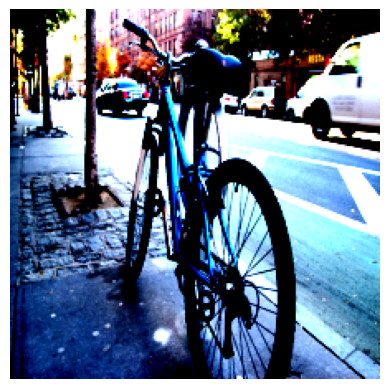

 50%|█████     | 5/10 [00:00<00:00, 18.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877128].


BLEU-4 Score: 0.0075511242363041535
torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a bathroom bathroom with with a a toilet toilet and and a a sink sink . . <end> for Image ID: 000000403385.jpg


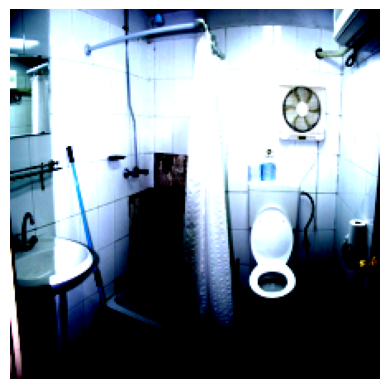

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


BLEU-4 Score: 0.0072393564882701315
torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a bathroom bathroom with with a a toilet toilet and and a a sink sink . . <end> for Image ID: 000000006818.jpg


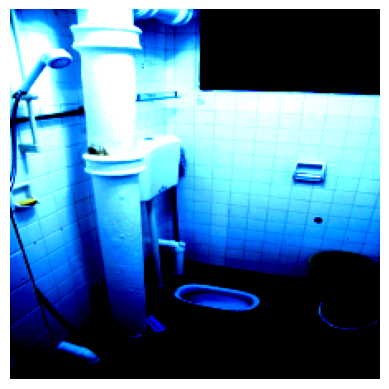

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


BLEU-4 Score: 0.007578138385599522
torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a man man riding on a a motorcycle motorcycle with in a the <unk> background . . <end> for Image ID: 000000480985.jpg


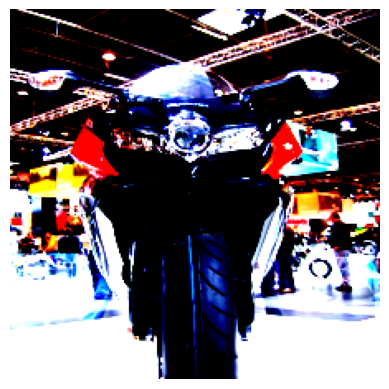

 80%|████████  | 8/10 [00:00<00:00, 20.29it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


BLEU-4 Score: 0.0074134798232975705
torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a woman woman in in a a kitchen kitchen with with a <unk> <unk> <unk> <unk> . . for Image ID: 000000458054.jpg


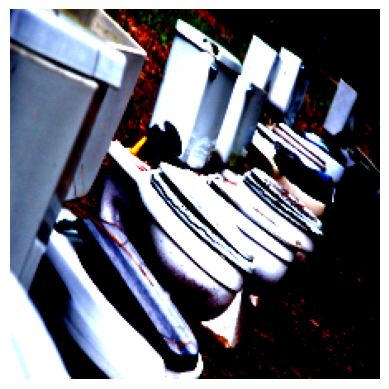

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7172985..2.64].


BLEU-4 Score: 0.007247667083027268
torch.Size([3, 224, 224])
Predicted Caption:<start> <start> a a toilet toilet with with a a <unk> <unk> <unk> <unk> on on it it . . <end> for Image ID: 000000331352.jpg


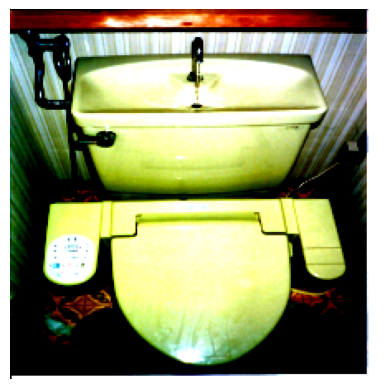

100%|██████████| 10/10 [00:00<00:00, 19.86it/s]

BLEU-4 Score: 0.007245132408669365


In [25]:
from pycocotools.coco import COCO
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

coco_val = COCO(VAL_CAPTIONS_PATH)
val_img_ids = coco_val.getImgIds()

predictions = []
references = {}
smoothie = SmoothingFunction().method4
scores = []

import matplotlib.pyplot as plt


print("Running Evaluation on 200 validation images...")
subset_ids = val_img_ids[:10]   # Evaluate on 200 images (faster)

for img_id in tqdm.tqdm(subset_ids):
    # Load the actual image file name
    img_info = coco_val.loadImgs(img_id)[0]
    file_name = img_info["file_name"]

    # Load image
    img_path = f"{VAL_IMAGES_PATH}/{file_name}"
    image = Image.open(img_path).convert("RGB")
    image = transform(image).to(device)

    print(image.shape)

    # Generate prediction
    pred_caption = generate_caption(image, encoder, decoder, vocab)
    print(f"Predicted Caption:{pred_caption} for Image ID: {file_name}")
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    pred_tokens = pred_caption.lower().split()

    # Ground truth captions
    ann_ids = coco_val.getAnnIds(imgIds=img_id)
    anns = coco_val.loadAnns(ann_ids)
    gt_caps = [ann["caption"] for ann in anns]

    # Compute BLEU-4
    bleu4 = sentence_bleu(gt_caps, pred_tokens, smoothing_function=smoothie)
    scores.append(bleu4)
    
    print("BLEU-4 Score:", sum(scores) / len(scores))

In [ ]:
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'vocab': vocab,
    'embed_size': 256,
    'hidden_size': 512
}, 'model.pth')